In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-closed-dataset/heart_2022_cleaned.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.svm import LinearSVC,SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
# IMPORT XGBOOST
from xgboost import XGBClassifier
import warnings
import pickle
from sklearn.preprocessing import OneHotEncoder
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
import scipy.sparse as sp

In [3]:
from sklearnex import patch_sklearn

In [4]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
metrics={'times':{},'accuracies':{},'macro_f1s':{},'macro_f1s_train':{},'accuracies_train':{}}

In [6]:
def model_classifier(X_train,X_test,y_train,y_test,model,model_name):
    mod = model
    params = mod.get_params()
    print(params)
        
    print(mod)
    print(f"{model_name} training")
    start_time = time.time()
    mod.fit(X_train, y_train)
    end_time = time.time()
    y_pred = mod.predict(X_test)
    y_pred_train = mod.predict(X_train)
    
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    accuracy_train = accuracy_score(y_train, y_pred_train)
    macro_f1_train = f1_score(y_train, y_pred_train, average='macro')

    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    metrics['times'][model_name] = (end_time-start_time)
    metrics['accuracies'][model_name] = accuracy
    metrics['macro_f1s'][model_name] = macro_f1
    metrics['accuracies_train'][model_name] = accuracy_train
    metrics['macro_f1s_train'][model_name] = macro_f1_train
    
    print("Accuracy:", accuracy)
    print("Macro f1:",macro_f1)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", report)
    return mod

### Reading the dataset and performing the train test split ###

In [7]:
data = pd.read_csv('/kaggle/input/heart-closed-dataset/heart_2022_cleaned.csv')
print(data.shape)
data.columns

(354862, 40)


Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [8]:
categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features

['State',
 'Sex',
 'GeneralHealth',
 'LastCheckupTime',
 'PhysicalActivities',
 'RemovedTeeth',
 'HadHeartAttack',
 'HadAngina',
 'HadStroke',
 'HadAsthma',
 'HadSkinCancer',
 'HadCOPD',
 'HadDepressiveDisorder',
 'HadKidneyDisease',
 'HadArthritis',
 'HadDiabetes',
 'DeafOrHardOfHearing',
 'BlindOrVisionDifficulty',
 'DifficultyConcentrating',
 'DifficultyWalking',
 'DifficultyDressingBathing',
 'DifficultyErrands',
 'SmokerStatus',
 'ECigaretteUsage',
 'ChestScan',
 'RaceEthnicityCategory',
 'AgeCategory',
 'AlcoholDrinkers',
 'HIVTesting',
 'FluVaxLast12',
 'PneumoVaxEver',
 'TetanusLast10Tdap',
 'HighRiskLastYear',
 'CovidPos']

In [9]:
numerical_columns = data.select_dtypes(include=['number']).columns
numerical_columns

Index(['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
       'HeightInMeters', 'WeightInKilograms', 'BMI'],
      dtype='object')

In [10]:
# Perform train test split
# y = data['GeneralHealth']
# X = data.drop('GeneralHealth', axis=1)
standard_scaler = StandardScaler()  
label_encoder = LabelEncoder()


for i in categorical_features:
    data[i] = label_encoder.fit_transform(data[i])

X_train,X_test = train_test_split(data,test_size=0.2, random_state=42)
X_train.shape, X_test.shape


X_train[numerical_columns] = standard_scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = standard_scaler.transform(X_test[numerical_columns])

Y_test = X_test.pop('GeneralHealth')
Y_train = X_train.pop('GeneralHealth')


X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


((283889, 39), (70973, 39), (283889,), (70973,))

### Naive Bayes ###

**Default**

In [11]:
model_naive  = model_classifier(X_train,X_test,Y_train,Y_test,GaussianNB(),"Naive_Bayes")
pickle.dump(model_naive, open('naive_bayes_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


{'priors': None, 'var_smoothing': 1e-09}
GaussianNB()
Naive_Bayes training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy: 0.32570132303833854
Macro f1: 0.34382288948295875
Confusion Matrix:
 [[ 9109   344   972    56   910]
 [ 1142  3272  2232  1996   930]
 [ 8979  3722  5249   828  3777]
 [   62   854   262  1934    56]
 [15541  1544  3429   221  3552]]
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.80      0.39     11391
           1       0.34      0.34      0.34      9572
           2       0.43      0.23      0.30     22555
           3       0.38      0.61      0.47      3168
           4       0.39      0.15      0.21     24287

    accuracy                           0.33     70973
   macro avg       0.36      0.43      0.34     70973
weighted avg       0.37      0.33      0.30     70973



### Logistic Regression ###

**Default**

In [12]:
model_logistic = model_classifier(X_train,X_test,Y_train,Y_test,LogisticRegression(verbose=True),"Logistic_Regression")
pickle.dump(model_logistic, open('model_logistic_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': True, 'warm_start': False}
LogisticRegression(verbose=True)
Logistic_Regression training


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.56902D+05    |proj g|=  1.22481D+06

At iterate   50    f=  3.41572D+05    |proj g|=  9.62326D+03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU



At iterate  100    f=  3.35617D+05    |proj g|=  2.81860D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  200    100    111      1     0     0   2.819D+04   3.356D+05
  F =   335617.13154350541     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Accuracy: 0.45342595071365166
Macro f1: 0.37178059024009225
Confusion Matrix:
 [[  888    76  1531    35  8861]
 [   73  2629  4877   691  1302]
 [  526  1276 10638   234  9881]
 [    3  1578   540   963    84]
 [  765   335  6053    71 17063]]
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.08    

In [13]:
lr_model = LogisticRegression(random_state=42)

lr_param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1],           
    'solver': ['liblinear', 'saga'] 
}

lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=-1)
print("-" * 20, "METRICS ON DATASET (Logistic Regression)", "-" * 20)
model_logistic = model_classifier(X_train,X_test,Y_train,Y_test,lr_grid,"Logistic_Regression")
pickle.dump(model_logistic, open('model_logistic_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (Logistic Regression) --------------------
{'cv': 3, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 42, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(random_state=42), 'n_jobs': -1, 'param_grid': {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1], 'solver': ['liblinear', 'saga']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 4}
GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1], 'penalty': ['l2'],
                         'solver': [

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on 

Accuracy: 0.46006227720400716
Macro f1: 0.39730083644419
Confusion Matrix:
 [[ 1016   100  1612    13  8650]
 [   49  2880  4756   632  1255]
 [  460  1490 10503   141  9961]
 [    3  1396   497  1195    77]
 [  861   389  5937    42 17058]]
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.09      0.15     11391
           1       0.46      0.30      0.36      9572
           2       0.45      0.47      0.46     22555
           3       0.59      0.38      0.46      3168
           4       0.46      0.70      0.56     24287

    accuracy                           0.46     70973
   macro avg       0.48      0.39      0.40     70973
weighted avg       0.46      0.46      0.43     70973



### Random Forest ###

**Default**

In [14]:
model_rf = model_classifier(X_train,X_test,Y_train,Y_test,RandomForestClassifier(verbose=True,n_jobs=-1),"Random_Forest")
pickle.dump(model_rf, open('model_rf_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': True, 'warm_start': False}
RandomForestClassifier(n_jobs=-1, verbose=True)
Random_Forest training


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_fi

Accuracy: 0.45331323179237176
Macro f1: 0.4169643216040336
Confusion Matrix:
 [[ 2330   116  2195    12  6738]
 [   85  3258  4587   629  1013]
 [  932  1898 11572   152  8001]
 [    4  1509   470  1123    62]
 [ 2314   522  7512    49 13890]]
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.20      0.27     11391
           1       0.45      0.34      0.39      9572
           2       0.44      0.51      0.47     22555
           3       0.57      0.35      0.44      3168
           4       0.47      0.57      0.51     24287

    accuracy                           0.45     70973
   macro avg       0.47      0.40      0.42     70973
weighted avg       0.45      0.45      0.44     70973



In [15]:
rf_model = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [50, 100],       
    'max_depth': [None, 10],         
    'min_samples_split': [2, 5],     
    'min_samples_leaf': [1, 2]       
}

rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=4)
print("-" * 20, "METRICS ON DATASET (Random Forest)", "-" * 20)
model_rf = model_classifier(X_train,X_test,Y_train,Y_test,rf_grid,"Random_Forest")
pickle.dump(model_rf, open('model_rf_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (Random Forest) --------------------
{'cv': 3, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(random_state=42), 'n_jobs': 4, 'param_grid': {'n_estimators': [50, 100], 'max_depth': [None, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 2}
Grid

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/3] END ..C=0.001, penalty=l2, solver=saga;, score=0.379 total time=  43.3s
[CV 3/3] END C=0.01, penalty=l2, solver=liblinear;, score=0.348 total time=  23.8s
[CV 3/3] END ...C=0.01, penalty=l2, solver=saga;, score=0.395 total time=  41.4s
[CV 3/3] END C=0.1, penalty=l2, solver=liblinear;, score=0.351 total time=  25.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  49.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.3min


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation.

Accuracy: 0.463260676595325
Macro f1: 0.420702355159318
Confusion Matrix:
 [[ 2148    96  2107    11  7029]
 [   61  3215  4668   624  1004]
 [  735  1746 11714   142  8218]
 [    4  1477   503  1124    60]
 [ 1881   482  7198    48 14678]]
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.19      0.26     11391
           1       0.46      0.34      0.39      9572
           2       0.45      0.52      0.48     22555
           3       0.58      0.35      0.44      3168
           4       0.47      0.60      0.53     24287

    accuracy                           0.46     70973
   macro avg       0.48      0.40      0.42     70973
weighted avg       0.46      0.46      0.45     70973



### Decision Tree ###

**Default**

In [16]:
model_dt = model_classifier(X_train,X_test,Y_train,Y_test,DecisionTreeClassifier(),"Decision_Tree")
pickle.dump(model_dt, open('model_dt_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
DecisionTreeClassifier()
Decision_Tree training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy: 0.35644540881743764
Macro f1: 0.33697475911323554
Confusion Matrix:
 [[3165  488 2843   60 4835]
 [ 597 2795 3315 1097 1768]
 [2930 3259 8459  587 7320]
 [  69 1129  659 1047  264]
 [5005 1841 7357  252 9832]]
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.28      0.27     11391
           1       0.29      0.29      0.29      9572
           2       0.37      0.38      0.37     22555
           3       0.34      0.33      0.34      3168
           4       0.41      0.40      0.41     24287

    accuracy                           0.36     70973
   macro avg       0.34      0.34      0.34     70973
weighted avg       0.36      0.36      0.36     70973



In [17]:
dt_model = DecisionTreeClassifier(random_state=42)

dt_param_grid = {
    'criterion': ['gini', 'entropy'],     
    'max_depth': [5, 10],              
    'min_samples_split': [2, 5],          
    'min_samples_leaf': [1, 2]            
}

dt_grid = GridSearchCV(dt_model, dt_param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=4)
print("-"*20,"METRICS ON DATASET", "-"*20)
model_dt_grid = model_classifier(X_train,X_test,Y_train,Y_test,dt_grid,"Decision_Tree")
pickle.dump(model_dt_grid, open('model_dt_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET --------------------
{'cv': 3, 'error_score': nan, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': 42, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(random_state=42), 'n_jobs': 4, 'param_grid': {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 2}
GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10],
                         'min_sampl

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy: 0.44901582291857467
Macro f1: 0.4068165458344266
Confusion Matrix:
 [[ 1965   153  1743    18  7512]
 [   79  3179  4235   773  1306]
 [  713  2005 10342   202  9293]
 [    6  1438   466  1175    83]
 [ 1831   606  6584    59 15207]]
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.17      0.25     11391
           1       0.43      0.33      0.38      9572
           2       0.44      0.46      0.45     22555
           3       0.53      0.37      0.44      3168
           4       0.46      0.63      0.53     24287

    accuracy                           0.45     70973
   macro avg       0.46      0.39      0.41     70973
weighted avg       0.45      0.45      0.43     70973



### SVM ###

**Default**

In [18]:
model_svm = model_classifier(X_train,X_test,Y_train,Y_test,SVC(verbose=True),"SVM")
pickle.dump(model_svm, open('model_svm_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
SVC(verbose=True)
SVM training
[LibSVM]............[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.3min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  35.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  17.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  16.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  17.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2,

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy: 0.4502839107829738
Macro f1: 0.33044099596668675
Confusion Matrix:
 [[    5   130  1343     5  9908]
 [    1  2910  4938   223  1500]
 [    8  1420  9737    43 11347]
 [    0  1954   534   582    98]
 [    5   484  5060    14 18724]]
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.00      0.00     11391
           1       0.42      0.30      0.35      9572
           2       0.45      0.43      0.44     22555
           3       0.67      0.18      0.29      3168
           4       0.45      0.77      0.57     24287

    accuracy                           0.45     70973
   macro avg       0.45      0.34      0.33     70973
weighted avg       0.43      0.45      0.40     70973



### Ada Boost ###


**Default**

In [19]:
model_ada = model_classifier(X_train,X_test,Y_train,Y_test,AdaBoostClassifier(),"ADA_Boost")
pickle.dump(model_ada, open('model_ada_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}
AdaBoostClassifier()
ADA_Boost training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._

Accuracy: 0.45713158525072917
Macro f1: 0.38212009585746487
Confusion Matrix:
 [[  499   109  1648    15  9120]
 [   41  3283  4384   649  1215]
 [  358  1913 10432   130  9722]
 [    2  1523   474  1097    72]
 [  420   452  6232    50 17133]]
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.04      0.08     11391
           1       0.45      0.34      0.39      9572
           2       0.45      0.46      0.46     22555
           3       0.57      0.35      0.43      3168
           4       0.46      0.71      0.56     24287

    accuracy                           0.46     70973
   macro avg       0.46      0.38      0.38     70973
weighted avg       0.45      0.46      0.42     70973



In [20]:
ab_model = AdaBoostClassifier(random_state=42)

ab_param_grid = {
    'n_estimators': [50, 100],     
    'learning_rate': [0.01, 0.1, 1] 
}

ab_grid = GridSearchCV(ab_model, ab_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=4)
print("-" * 20, "METRICS ON DATASET (AdaBoost)", "-" * 20)
model_ada_grid = model_classifier(X_train,X_test,Y_train,Y_test,ab_grid,"ADA_Boost")
pickle.dump(model_ada_grid, open('model_ada_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (AdaBoost) --------------------
{'cv': 3, 'error_score': nan, 'estimator__algorithm': 'SAMME.R', 'estimator__base_estimator': 'deprecated', 'estimator__estimator': None, 'estimator__learning_rate': 1.0, 'estimator__n_estimators': 50, 'estimator__random_state': 42, 'estimator': AdaBoostClassifier(random_state=42), 'n_jobs': 4, 'param_grid': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 4}
GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100]},
             scoring='f1_macro', verbose=4)
ADA_Boost training
Fitting 3 folds for each of 6 candidates, totalling 18 fits


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._a

Accuracy: 0.4623730150902456
Macro f1: 0.40389934403954025
Confusion Matrix:
 [[ 1097   118  1577    13  8586]
 [  101  3312  4380   667  1112]
 [  750  1818 10490   149  9348]
 [    5  1454   454  1187    68]
 [  930   447  6122    58 16730]]
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.10      0.15     11391
           1       0.46      0.35      0.40      9572
           2       0.46      0.47      0.46     22555
           3       0.57      0.37      0.45      3168
           4       0.47      0.69      0.56     24287

    accuracy                           0.46     70973
   macro avg       0.47      0.39      0.40     70973
weighted avg       0.45      0.46      0.44     70973



### XG Boost ###

**Default**

In [21]:
model_xg = model_classifier(X_train,X_test,Y_train,Y_test,XGBClassifier(),"XG_Boost")
pickle.dump(model_xg, open('model_xg_default.pkl', 'wb'))

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, c

In [22]:
xgb_model = XGBClassifier(random_state=42)

xgb_param_grid = {
    'n_estimators': [50, 100],     
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 7],      
    'subsample': [0.8, 1.0]    
}

# Setup GridSearchCV
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=4)

# Train and save the model
print("-" * 20, "METRICS ON DATASET (XGBoost)", "-" * 20)
model_xgb_grid = model_classifier(X_train, X_test, Y_train, Y_test, xgb_grid, "XG_Boost")
pickle.dump(model_xgb_grid, open('model_xgb_grid.pkl', 'wb'))


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (XGBoost) --------------------
{'cv': 3, 'error_score': nan, 'estimator__objective': 'binary:logistic', 'estimator__base_score': None, 'estimator__booster': None, 'estimator__callbacks': None, 'estimator__colsample_bylevel': None, 'estimator__colsample_bynode': None, 'estimator__colsample_bytree': None, 'estimator__device': None, 'estimator__early_stopping_rounds': None, 'estimator__enable_categorical': False, 'estimator__eval_metric': None, 'estimator__feature_types': None, 'estimator__gamma': None, 'estimator__grow_policy': None, 'estimator__importance_type': None, 'estimator__interaction_constraints': None, 'estimator__learning_rate': None, 'estimator__max_bin': None, 'estimator__max_cat_threshold': None, 'estimator__max_cat_to_onehot': None, 'estimator__max_delta_step': None, 'estimator__max_depth': None, 'estimator__max_leaves': None, 'estimator__min_child_weight': None, 'estimator__missing': nan, 'estimator__monotone_constraints': None, 'es

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/3] END learning_rate=0.01, n_estimators=100;, score=0.228 total time=  39.2s
[CV 2/3] END learning_rate=0.1, n_estimators=50;, score=0.268 total time=  19.0s
[CV 1/3] END learning_rate=0.1, n_estimators=100;, score=0.301 total time=  38.7s
[CV 1/3] END .learning_rate=1, n_estimators=100;, score=0.402 total time=  33.1s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8;, score=0.378 total time=  15.5s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0;, score=0.377 total time=  14.8s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8;, score=0.378 total time=  29.5s
[CV 1/3] END learning_rate=0.01, n_estimators=50;, score=0.219 total time=  20.3s
[CV 3/3] END learning_rate=0.01, n_estimators=100;, score=0.232 total time=  38.5s
[CV 3/3] END learning_rate=0.1, n_estimators=100;, score=0.300 total time=  38.0s
[CV 3/3] END ..learning_rate=1, n_estimators=50;, score=0.391 total time=  19.1s
[CV 1/3] END l

In [23]:
df = pd.DataFrame(metrics)
df.to_csv("Metrics.csv")
df

,times,accuracies,macro_f1s,macro_f1s_train,accuracies_train
Naive_Bayes,0.298041,0.325701,0.343823,0.339044,0.323158
Logistic_Regression,216.566782,0.460062,0.397301,0.397336,0.460934
Random_Forest,588.541620,0.463261,0.420702,0.952327,0.957758
Decision_Tree,25.924320,0.449016,0.406817,0.434444,0.467626
SVM,14529.055002,0.450284,0.330441,0.330647,0.451155
ADA_Boost,170.286509,0.462373,0.403899,0.401387,0.462061
XG_Boost,321.597561,0.471841,0.430757,0.478695,0.504236


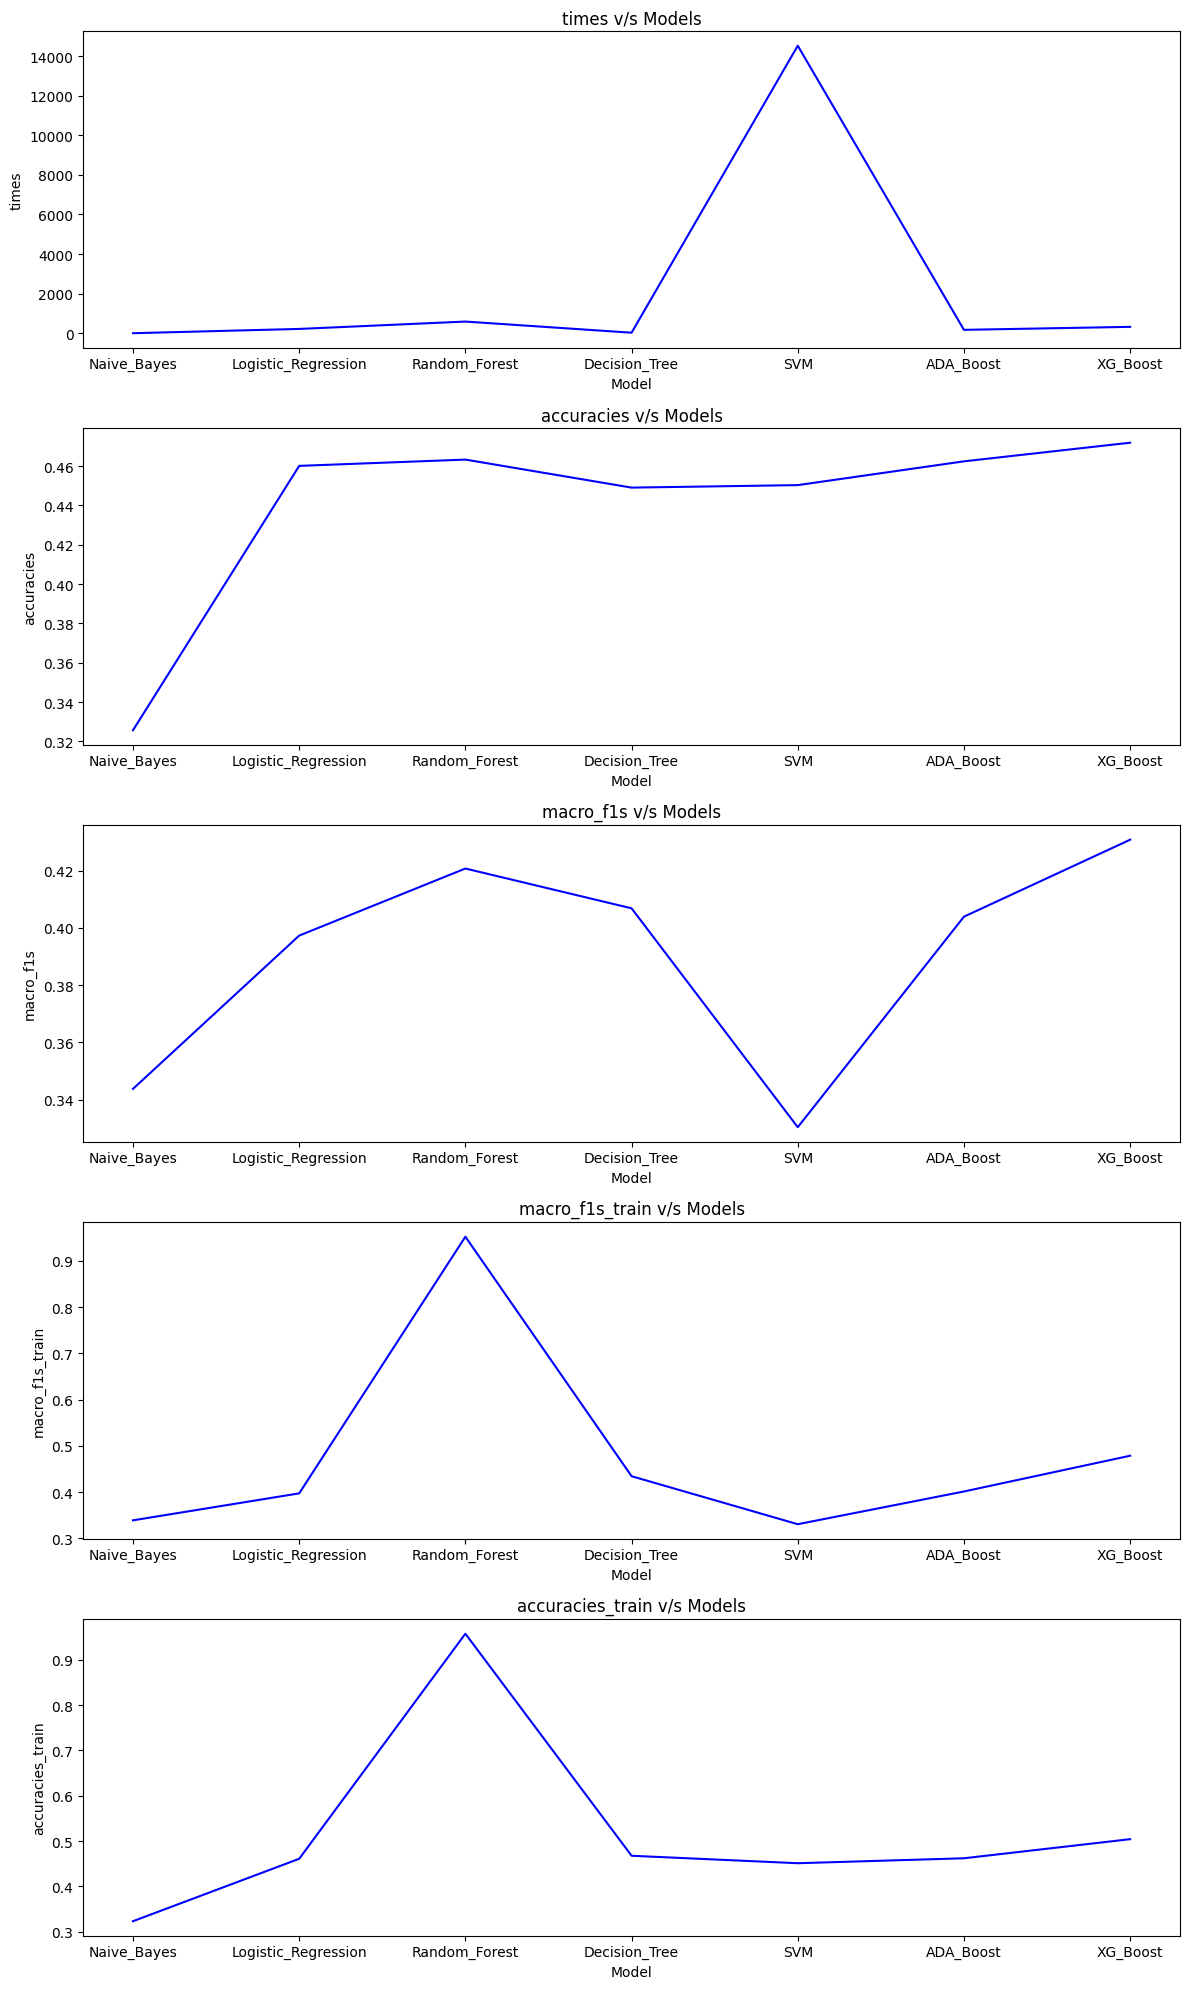

In [24]:
models = [df.index[i] for i in range(df.shape[0])]
metrics = [df.columns[i] for i in range(df.shape[1])]

fig,axes = plt.subplots(5,figsize=(12,20))

for i in range(len(metrics)):
    # print(i)
    # print(row)
    row = df.iloc[:,i]
    axes[i].set_title(f"{metrics[i]} v/s Models")
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel(f"{metrics[i]}")
    axes[i].plot(models,row,color='blue')
    
plt.tight_layout()
plt.savefig("Metrics.png")
plt.show()